# Note
All the code inside this notebook has been adapted from two notebooks aviable online at: https://github.com/kylewest520/CS-7641---Machine-Learning/tree/master/Assignment%201%20Supervised%20Learning and https://github.com/niranjantdesai/cs-7641-machine-learning/tree/master/assgn1-supervised_learning

In [2]:
#from load_data import load_breast_cancer_data, load_mushroom_data, load_wine_quality_data

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
import importlib
import random
import time
import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Data loading and preprocessing
Let's load the data, standardize it and split it into training and test sets.
This dataset comes from https://www.kaggle.com/akashkr/phishing-website-dataset

In [3]:
file = r".\phisingwebsitesdataset.csv"

def load_phishing_data(filename):
    """
    Loads the Phishing website dataset 
    :param filename: path to csv file
    :return: X (data) and y (labels)
    """

    data = pd.read_csv(filename,delimiter=",")
    # y includes our labels and x includes our features
    y = data.Result # win  lose or draw
    # "Result" as it is the label
    to_drop = ['Result']

    
    X = data.drop(to_drop, axis=1)
    X=X.values
    y = y.values
    

    y = y.astype(int)
    return X, y
X,y = load_phishing_data(file)
print(X[0:3])

[[ 1 -1  1  1  1 -1 -1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1 -1  0  1  1  1  1
  -1 -1 -1 -1  1  1 -1]
 [ 2  1  1  1  1  1 -1  0  1 -1  1  1 -1  1  0 -1 -1  1  1  0  1  1  1  1
  -1 -1  0 -1  1  1  1]
 [ 3  1  0  1  1  1 -1 -1 -1 -1  1  1 -1  1  0 -1 -1 -1 -1  0  1  1  1  1
   1 -1  1 -1  1  0 -1]]


In [4]:
# Read data

print('Total number of examples in the dataset: %d' % X.shape[0])
print('Fraction of positive examples: %.2f%%' % (y[y == 1].shape[0]/y.shape[0]*100.0))

# Standardize data
X = preprocessing.scale(X)

# Split into training and test data. Use random_state to get the same results in every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=18)

# Data structures for storing best accuracies, training time and test time
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

Total number of examples in the dataset: 11055
Fraction of positive examples: 55.69%


The fraction of positive examples suggests that our data is balanced.

## Helper functions

In [92]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import itertools
import timeit

def plot_learning_curve(clf, X, y, title="Insert Title"):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='accuracy', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean
    

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Accuracy")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="royalblue")
    plt.fill_between(train_sizes, cv_mean - cv_std, cv_mean + cv_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_mean, 'o-', color="royalblue", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="orange", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - fit_std, fit_mean + fit_std, alpha=0.1, color="royalblue")
    plt.fill_between(train_sizes, pred_mean - pred_std, pred_mean + pred_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, fit_mean, 'o-', color="royalblue", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="orange", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test):
    '''    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
   ''' 
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    cm = confusion_matrix(y_test,y_pred)

    print("Model Evaluation Metrics Using Untouched Test Dataset")
    print("*****************************************************")
#    print("Model Training Time (s):   "+"{:.5f}".format(training_time))
    print("Model Prediction Time (s): "+"{:.5f}\n".format(pred_time))
    print("F1 Score:  "+"{:.2f}".format(f1))
    print("Accuracy:  "+"{:.2f}".format(accuracy)+"     AUC:       "+"{:.2f}".format(auc))
    print("Precision: "+"{:.2f}".format(precision)+"     Recall:    "+"{:.2f}".format(recall))
    print("*****************************************************")
    plt.figure()
    plot_confusion_matrix(cm, classes=["0","1"], title='Confusion Matrix')
    plt.show()


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(2), range(2)):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


# Decision tree
Let's first train a decision tree without any optimization to get a feel for its performance on the given data.

In [141]:
clf_dt = tree.DecisionTreeClassifier(random_state=7)
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree without hyperparameter tuning is %.2f%%' % (dt_accuracy*100))

Accuracy of decision tree without hyperparameter tuning is 94.75%


## Validation curve
We will use a form of pre-pruning to prevent overfitting. Performance of a decision tree is affected by its maximum depth. A tree with a large depth will try to fit the training data exactly and is likely to result in overfitting. Let's plot the training and cross-validation scores to get a sense of how much the tree overfits with an increase in the depth.

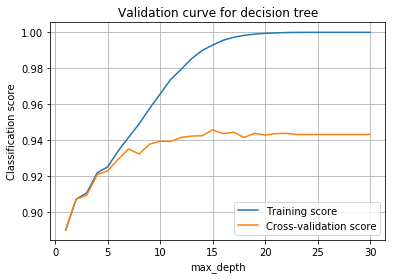

In [142]:
depth_range = np.arange(30) + 1
train_scores, test_scores = validation_curve(clf_dt, X_train, y_train, param_name="max_depth", param_range=depth_range, cv=5,
                                            n_jobs=4)

plt.figure()
#plt.xticks(depth_range)
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()




For low values of max_depth, the tree is excessively pruned and thus suffers from underfitting as both the training and cross-validation scores are low. The training score keeps increasing as max_depth increases. However, the cross-validation score first increases but starts decreasing at a certain point and then plateaus. Thus, at higher values of max_depth, the tree starts to overfit.

## Hyperparameter tuning
Based on the validation curve above, we will define an appropriate grid for max_depth, tune it and find out the best accuracy using a decision tree.

In [143]:
depth_range = np.arange(20) + 1
tuned_params = {'max_depth' : depth_range}
clf_dt = GridSearchCV(clf_dt, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_dt.fit(X_train, y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_dt = clf_dt
best_dt_params = clf_dt.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)
t0 = time.time()
y_pred = clf_dt.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

Completed training in 0.605840 seconds
Best parameters set for decision tree found on development set:
{'max_depth': 15}
Inference time on test data: 0.000998 seconds
Accuracy of decision tree is 95.07%


## Learning curve

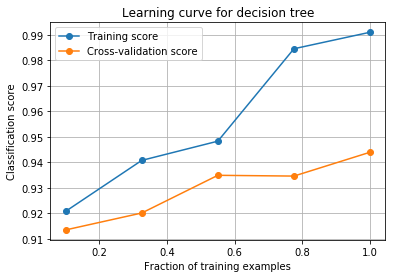

In [43]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_dt, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# Model evaluation

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00071

F1 Score:  0.96
Accuracy:  0.95     AUC:       0.95
Precision: 0.95     Recall:    0.96
*****************************************************


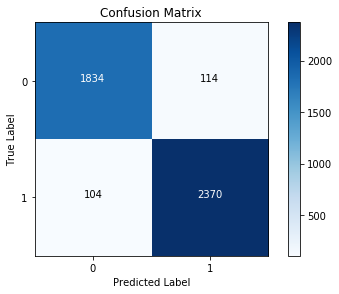

In [144]:
final_classifier_evaluation(clf_dt, X_train, X_test, y_train, y_test)

# Neural network
Due to computational complexity, we experimented with a small neural networks.The parameters we tuned are the number of units, the learning rate and the L2 penalty term alpha. We did this for several numbers of hidden layers, but this last parameters did not change the results drastically, so we kept the simple neural network with only one hidden layer.

In [16]:
nb_layers=1

def hyperNN(X_train, y_train, X_test, y_test, title):

    accuracy_test = []
    accuracy_train = []
    hlist = np.linspace(1,100,30).astype('int')
    for i in hlist:         
            clf_nn = MLPClassifier(hidden_layer_sizes=(i,nb_layers), solver='adam', activation='logistic', 
                                learning_rate_init=0.05, random_state=100)
            clf_nn.fit(X_train, y_train)
            y_pred_test = clf_nn.predict(X_test)
            y_pred_train = clf_nn.predict(X_train)
            accuracy_test.append(accuracy_score(y_test, y_pred_test))
            accuracy_train.append(accuracy_score(y_train, y_pred_train))
            
      
    plt.plot(hlist, accuracy_test, 'o-', color='orange', label='Test Accuracy')
    plt.plot(hlist, accuracy_train, 'o-', color = 'royalblue', label='Train Accuracy')
    plt.ylabel('Model Accuracy')
    plt.xlabel('No. Hidden Units')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    learning_rates = [0.01, 0.05, .1]
    alpha_rates = [0.01, 0.1, 1, 10, 100]
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': learning_rates, 'alpha':alpha_rates}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',activation='logistic',random_state=100),
                       param_grid=param_grid, cv=10)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init'], net.best_params_['alpha'], net

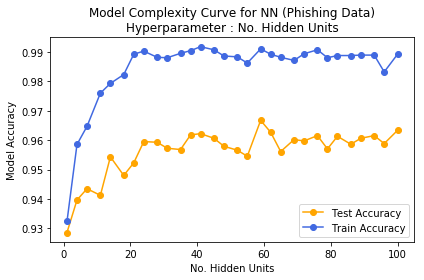

In [17]:
hyperNN(X_train, y_train, X_test, y_test,"Model Complexity Curve for NN (Phishing Data)\nHyperparameter : No. Hidden Units")

In [78]:
clf_nn = MLPClassifier(hidden_layer_sizes=(60, 1), random_state=7, max_iter=1000)
clf_nn.fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network of 1 layer and 60 hidden units without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network of 1 layer and 60 hidden units without hyperparameter tuning is 95.61%


## Validation curve
Performance of a neural network is very sensitive to its learning rate and regularization parameter. Let's get a feel for it by plotting validation curves for both the parameters.

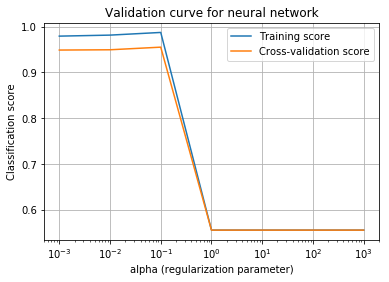

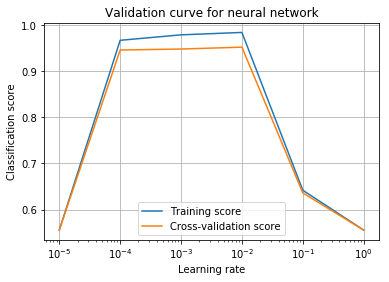

In [79]:
# Regularization parameter
alpha_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="alpha", param_range=alpha_range, cv=5,
                                            n_jobs=4)

plt.figure()
plt.semilogx(alpha_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(alpha_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('alpha (regularization parameter)')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Learning rate
lr_range = np.logspace(-5, 0, 6)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="learning_rate_init", param_range=lr_range, 
                                             cv=5, n_jobs=4)

plt.figure()
plt.semilogx(lr_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(lr_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('Learning rate')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_2.png')
plt.show()

## Hyperparameter tuning
Based on the validation curves plotted above, we will define an appropriate grid for each parameter and tune them.

In [80]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_nn.fit(X_train, y_train)
t1 = time.time()
train_time[1] = t1 - t0
print('Completed training in %f seconds' % train_time[1])
best_clf_nn = clf_nn
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Completed training in 631.548782 seconds
Best parameters set found on development set:
{'alpha': 0.1, 'learning_rate_init': 0.001}


## Learning curve

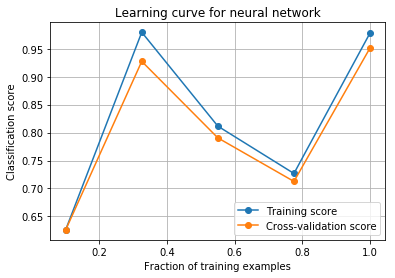

In [81]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_nn, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for neural network')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

## Loss curves
We will now observe how training error decreases with epochs.

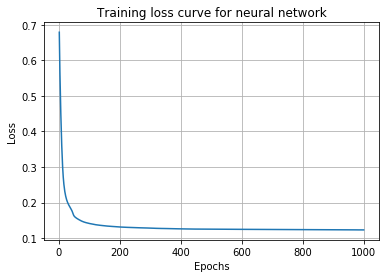

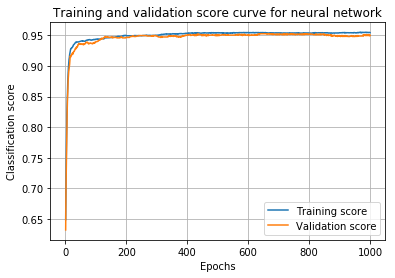

In [82]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1, warm_start=True)
clf_nn.set_params(alpha=best_params['alpha'], learning_rate_init=best_params['learning_rate_init'])
num_epochs = 1000
train_loss = np.empty(num_epochs)
train_scores = np.empty(num_epochs)
val_scores = np.empty(num_epochs)
# Split training set into training and validation
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=18)
for i in range(num_epochs):
    clf_nn.fit(X_train1, y_train1)
    train_loss[i] = clf_nn.loss_
    train_scores[i] = accuracy_score(y_train1, clf_nn.predict(X_train1))
    val_scores[i] = accuracy_score(y_val, clf_nn.predict(X_val))

y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)


xrange = np.arange(num_epochs) + 1
plt.figure()
plt.plot(xrange, train_loss)
plt.title('Training loss curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.grid()
#plt.savefig(fig_path + 'nn_train_loss.png')
plt.show()

plt.figure()
plt.plot(xrange, train_scores, label='Training score')
plt.plot(xrange, val_scores, label='Validation score')
plt.title('Training and validation score curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Classification score")
plt.grid()
plt.legend(loc="best")
#plt.savefig(fig_path + 'nn_score_curve.png')
plt.show()

## Evaluate optimal model
Let's find the test accuracy of the neural network with its hyperparameters tuned to their optimal values.

Best accuracy of neural network is 96.27%
Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.00379

F1 Score:  0.97
Accuracy:  0.96     AUC:       0.96
Precision: 0.97     Recall:    0.97
*****************************************************


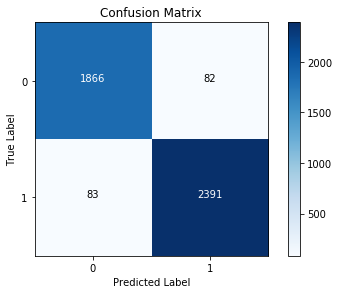

In [93]:
t0 = time.time()
y_pred = best_clf_nn.predict(X_test)
t1 = time.time()
test_time[1] = t1 - t0
best_accuracy[1] = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy[1] * 100))
final_classifier_evaluation(best_clf_nn, X_train, X_test, y_train, y_test)


In [45]:
t0 = time.time()
y_pred = best_clf_nn.predict(X_test)
t1 = time.time()
test_time[1] = t1 - t0

print('Inference time on test data: %f seconds' % test_time[1])
best_accuracy[1] = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy[1] * 100))

Inference time on test data: 0.000000 seconds
Best accuracy of neural network is 96.27%


# Boosting
We will use AdaBoost with decision stumps.

In [103]:
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, random_state=7)
clf_boosted.fit(X_train, y_train)
y_pred = clf_boosted.predict(X_test)
boosted_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost without hyperparameter tuning is %.2f%%' % (boosted_accuracy * 100))

Accuracy of Adaboost without hyperparameter tuning is 93.65%


## Validation curve
Number of weak learners is a hyperparameter we have to tune. To understand how it affects the performance of the classifier, we will plot training and cross-validation scores wrt the number of learners.

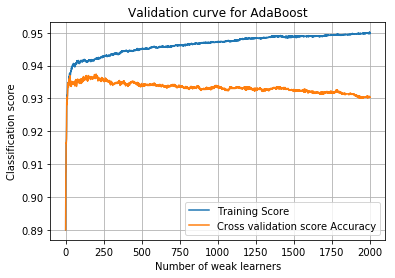

In [104]:
# Define AdaBoost learner
num_learners = 2000
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners, random_state=7)

# Cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=7)
train_scores = np.zeros((num_learners, num_folds))
val_scores = np.zeros((num_learners, num_folds))
for idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    clf_boosted.fit(X_train[train_index], y_train[train_index])
    train_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[train_index], y_train[train_index])))
    val_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[test_index], y_train[test_index])))

n_estimators_range = np.arange(num_learners) + 1
plt.figure()
plt.plot(n_estimators_range, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(n_estimators_range, np.mean(val_scores, axis=1), label='Cross validation score Accuracy')
plt.title('Validation curve for AdaBoost')
plt.xlabel('Number of weak learners')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

## Evaluate optimal model

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.84020

F1 Score:  0.94
Accuracy:  0.93     AUC:       0.93
Precision: 0.93     Recall:    0.96
*****************************************************


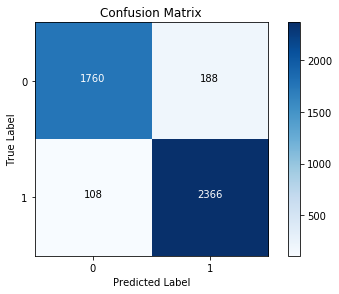

In [106]:
final_classifier_evaluation(clf_boosted, X_train, X_test, y_train, y_test)

In [107]:
num_learners_optimal = np.argmax(np.mean(val_scores, axis=1)) + 1
print('Optimal number of learners for AdaBoost: %d' % num_learners_optimal)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
t0 = time.time()
best_clf_boosted.fit(X_train, y_train)
t1 = time.time()
train_time[2] = t1 - t0
print('Completed training in %f seconds' % train_time[2])
t0 = time.time()
y_pred = best_clf_boosted.predict(X_test)
t1 = time.time()
test_time[2] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[2])
best_accuracy[2] = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost with the best hyperparameters is %.2f%%' % (best_accuracy[2] * 100))

Optimal number of learners for AdaBoost: 201
Completed training in 0.782658 seconds
Inference time on test data: 0.078825 seconds
Accuracy of Adaboost with the best hyperparameters is 93.67%


## Learning curve

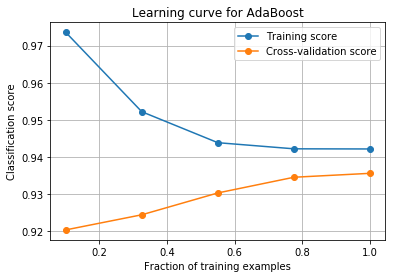

In [9]:
train_sizes = np.linspace(0.1, 1.0, 5)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
_, train_scores, test_scores = learning_curve(best_clf_boosted, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Test Accuracy')
plt.title('Learning curve for AdaBoost')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# SVM
We will first choose the kernel function to use:

In [56]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    accuracy_test = []
    accuracy_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    accuracy_test.append(accuracy_score(y_test, y_pred_test))
                    accuracy_train.append(accuracy_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                accuracy_test.append(accuracy_score(y_test, y_pred_test))
                accuracy_train.append(accuracy_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','poly4','poly5','poly6','poly7','poly8','rbf','sigmoid']
    plt.plot(xvals, accuracy_test, 'o-', color='orange', label='Test Accuracy')
    plt.plot(xvals, accuracy_train, 'o-', color = 'royalblue', label='Train Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

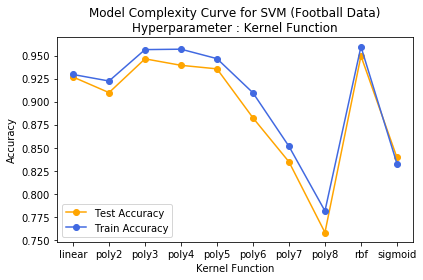

In [31]:
hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Football Data)\nHyperparameter : Kernel Function")

We chose to work with a rbf kernel function

In [57]:
svm_rbf = svm.SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

# Validation curve
Let's plot the training and cross-validation scores wrt the penalty parameter $C$ (which controls regularization).

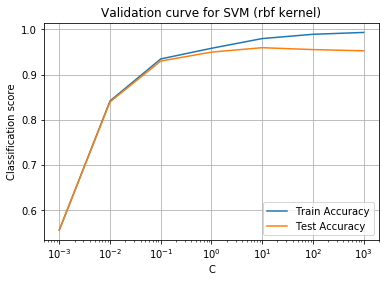

In [58]:
C_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(svm_rbf, X_train, y_train, param_name="C", param_range=C_range, cv=5, n_jobs=4)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Train Accuracy')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Test Accuracy')
plt.title('Validation curve for SVM (rbf kernel)')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Hyperparameter tuning
Based on the validation curve plotted above, we will now define an appropriate grid for $C$ and tune it.

In [59]:
C_range = np.logspace(-2, 1, 10)
tuned_params = {'C' : C_range}
svm_linear = GridSearchCV(svm_rbf, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
svm_linear.fit(X_train, y_train)
t1 = time.time()
train_time[3] = t1 - t0
print('Completed training in %f seconds' % train_time[3])
best_clf_svm = svm_linear
best_params = svm_linear.best_params_
print("Best parameters set found on development set:")
print(best_params)
t0 = time.time()
y_pred = best_clf_svm.predict(X_test)
t1 = time.time()
test_time[3] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[3])
best_accuracy[3] = accuracy_score(y_test, y_pred)
print('Best accuracy with SVM (rbf kernel) is %.2f%%' % (best_accuracy[3] * 100))

Completed training in 39.682701 seconds
Best parameters set found on development set:
{'C': 10.0}
Inference time on test data: 0.503744 seconds
Best accuracy with SVM (rbf kernel) is 95.84%


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Prediction Time (s): 0.42964

F1 Score:  0.96
Accuracy:  0.96     AUC:       0.96
Precision: 0.96     Recall:    0.97
*****************************************************


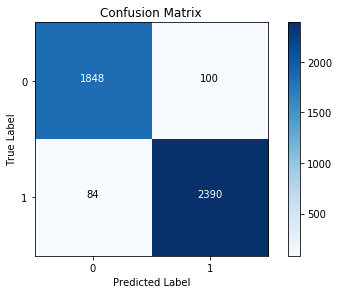

In [145]:
final_classifier_evaluation(svm_linear,X_train, X_test, y_train, y_test)

# Learning curve

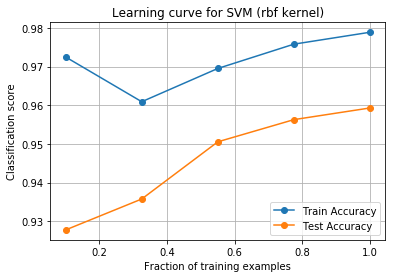

In [60]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_svm, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Test Accuracy')
plt.title('Learning curve for SVM (rbf kernel)')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# kNN

## Validation curve
Let's find out how the accuracies are affected by the number of neighbors.

In [ ]:
k_range = np.arange(1, 301)
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", 
                                             param_range=k_range, cv=5, n_jobs=4)

plt.figure()
plt.plot(k_range, np.mean(train_scores, axis=1), label='Train Accuracy')
plt.plot(k_range, np.mean(test_scores, axis=1), label='Test Accuracy')
plt.title('Validation curve for kNN')
plt.xlabel('k')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

## Evaluate optimal model
We will choose the value of k which gives the best cross-validation score and evaluate test score with that.

In [62]:
k_optimal = np.argmax(np.mean(test_scores, axis=1)) + 1
print('Optimal value of k: %d' % k_optimal)
best_clf_knn = KNeighborsClassifier(n_neighbors=k_optimal)
t0 = time.time()
best_clf_knn.fit(X_train, y_train)
t1 = time.time()
train_time[4] = t1 - t0
print('Completed training in %f seconds' % train_time[4])
t0 = time.time()
y_pred = best_clf_knn.predict(X_test)
t1 = time.time()
test_time[4] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[4])
best_accuracy[4] = accuracy_score(y_test, y_pred)
print('Accuracy of kNN with k = %d is %.2f%%' % (k_optimal, best_accuracy[4] * 100))

Optimal value of k: 1
Completed training in 0.043887 seconds
Inference time on test data: 0.808409 seconds
Accuracy of kNN with k = 1 is 95.50%


Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.04449
Model Prediction Time (s): 0.82998

F1 Score:  0.96
Accuracy:  0.95     AUC:       0.95
Precision: 0.96     Recall:    0.96
*****************************************************


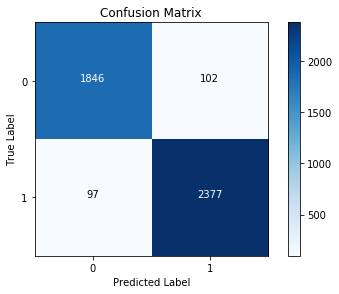

In [64]:
final_classifier_evaluation(best_clf_knn, X_train, X_test, y_train, y_test)

## Learning curve

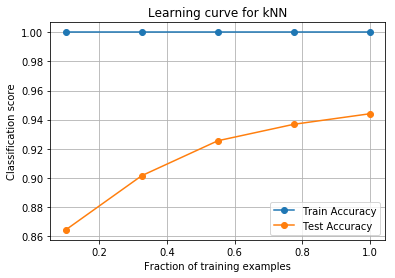

In [65]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_knn, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Train Accuracy')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross validation score')
plt.title('Learning curve for kNN')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# Comparing the classifiers
We will now compare the 5 classifiers with respect to accuracy, training time and inference time

In [66]:
classifiers = ('Decision tree', 'Neural network', 'AdaBoost', 'SVM', 'kNN')
y_pos = np.arange(len(classifiers))

## Accuracy

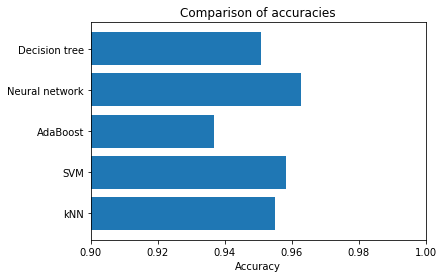

In [102]:
plt.figure()
plt.barh(y_pos, best_accuracy)
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.9, 1)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of accuracies')
plt.xlabel('Accuracy')
plt.show()

## Training time

[5.74032307e-01 6.31548782e+02 7.82658339e-01 3.96827009e+01
 4.38866615e-02]


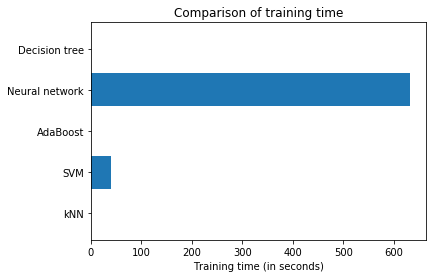

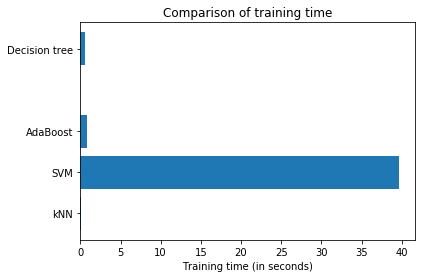

In [122]:
plt.figure()
plt.barh(y_pos, train_time)
print(train_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of training time')
plt.xlabel('Training time (in seconds)')
plt.show()


#now let's remove the neural network training time which hide the other ones
classifiers1 = ('Decision tree', 'AdaBoost', 'SVM', 'kNN')


y_pos1=[y_pos[0],y_pos[2],y_pos[3],y_pos[4]]
train_time1=[train_time[0],train_time[2],train_time[3],train_time[4]]
plt.barh(y_pos1, train_time1)
plt.gca().set_yticks(y_pos1)
plt.gca().set_yticklabels(classifiers1)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of training time')
plt.xlabel('Training time (in seconds)')
plt.show()

## Inference time

[0.         0.00398731 0.07882547 0.50374436 0.80840945]


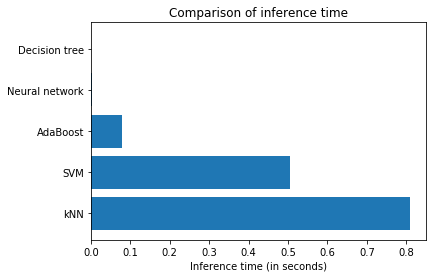

In [110]:
plt.figure()
plt.barh(y_pos, test_time)
print(test_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of inference time')
plt.xlabel('Inference time (in seconds)')
plt.show()